In [310]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical, load_img, img_to_array
from sklearn.metrics import confusion_matrix
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [311]:
os.listdir("dataset1/")

['readme.txt', 'known_images', 'unknown_images']

Load all the images

In [312]:
def load_images():
    images_dir = Path('dataset1/known_images/')
    normal_images = images_dir.glob('normal*.png')
    sick_images = images_dir.glob('sick*.png')
    img_data = []
    label_data = []
    for img in normal_images:
        img_data.append(img)
        label_data.append('normal')
    for img in sick_images:
        img_data.append(img)
        label_data.append('sick')
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df['labels'] = label_data
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [313]:
df_known_images = load_images()

df_known_images

,images,labels
0,dataset1\known_images\normal_193.png,normal
1,dataset1\known_images\sick_240.png,sick
2,dataset1\known_images\normal_147.png,normal
3,dataset1\known_images\sick_135.png,sick
4,dataset1\known_images\sick_286.png,sick
...,...,...
710,dataset1\known_images\sick_53.png,sick
711,dataset1\known_images\sick_157.png,sick
712,dataset1\known_images\normal_93.png,normal
713,dataset1\known_images\sick_52.png,sick


In [314]:
df_known_images.shape

(715, 2)

We now check if the data is balanced

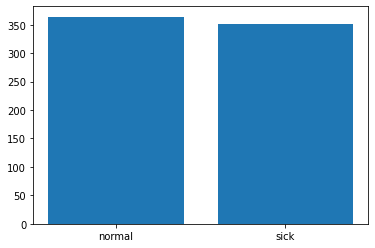

In [315]:
plt.bar(df_known_images['labels'].value_counts().index, df_known_images['labels'].value_counts().values)
plt.show()

Visualise some of the images

In [316]:
def visualise_images(images, labels):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(images[i]))
        img = cv2.resize(img, (224, 224))
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')

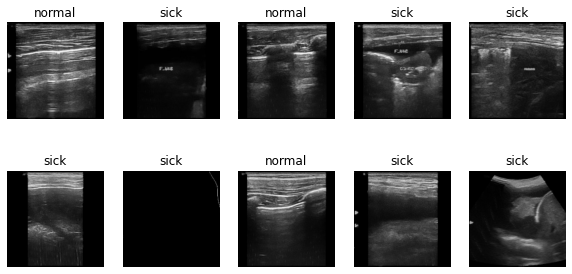

In [317]:
visualise_images(df_known_images['images'], df_known_images['labels'])

Split the data into Test and Training

In [318]:
'''
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1):
    
    assert (train_split + test_split + val_split) == 1
    
    # Only allows for equal validation and test splits
    assert val_split == test_split 

    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    #print(df_sample)
    indices_or_sections = [int(train_split * len(df)), int((1 - val_split - test_split) * len(df))]
    #print(indices_or_sections)
    
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds
'''
def get_dataset_partitions_pd(df, train_split=0.8):
    train=df.sample(frac=train_split,random_state=200) #random state is a seed value

    test_validation=df.drop(train.index)

    test=test_validation.sample(frac=0.5,random_state=200) 

    validation = test_validation.drop(test.index)

    assert len(df) == len(train) + len(test) + len(validation) 

    return train, validation, test



In [319]:
train_ds, val_ds, test_ds = get_dataset_partitions_pd(df_known_images)


In [320]:
test_ds

,images,labels
87,dataset1\known_images\normal_172.png,normal
188,dataset1\known_images\sick_149.png,sick
462,dataset1\known_images\sick_139.png,sick
567,dataset1\known_images\normal_286.png,normal
90,dataset1\known_images\normal_280.png,normal
...,...,...
284,dataset1\known_images\sick_98.png,sick
714,dataset1\known_images\normal_173.png,normal
187,dataset1\known_images\sick_170.png,sick
29,dataset1\known_images\normal_345.png,normal


Check if the training data is balanced

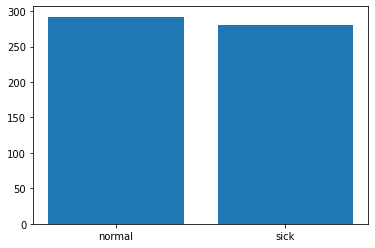

In [321]:
plt.bar(train_ds['labels'].value_counts().index, train_ds['labels'].value_counts().values)
plt.show()

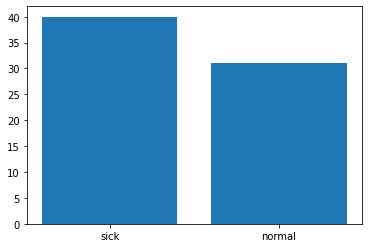

In [322]:
plt.bar(val_ds['labels'].value_counts().index, val_ds['labels'].value_counts().values)
plt.show()

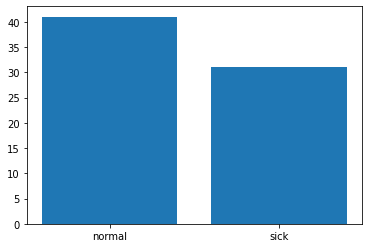

In [323]:
plt.bar(test_ds['labels'].value_counts().index, test_ds['labels'].value_counts().values)
plt.show()

Prepare the Validation Dataset, by processing the images through resizing and changing color scale to RGB

In [324]:
def prepare_dataset(images):
    '''
    if 'normal' in images['labels'].values:
        normal_cases = images
    if 'sick' in images['labels'].values:
        sick_cases = images
        #print(sick_cases['labels'])
    '''
    normal_cases = images.loc[images['labels'] == 'normal']
    sick_cases = images.loc[images['labels'] == 'sick']
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if 'normal' in case['labels'].values:
                #print(case['labels'])
                label = to_categorical(0 , num_classes=2)
            else:
                print(case['labels'])
                label = to_categorical(1 , num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(normal_cases)
    d,l = prepare(sick_cases)
    #print(l)
    d = np.array(d)
    l = np.array(l)
    return d,l



In [325]:
val_data, val_labels = prepare_dataset(val_ds)
print(val_data)
#visualise_images(val_data,val_labels)

43     sick
81     sick
84     sick
95     sick
104    sick
110    sick
117    sick
155    sick
168    sick
193    sick
216    sick
218    sick
219    sick
238    sick
243    sick
244    sick
248    sick
272    sick
282    sick
312    sick
327    sick
333    sick
349    sick
351    sick
353    sick
396    sick
408    sick
452    sick
498    sick
512    sick
526    sick
539    sick
554    sick
573    sick
666    sick
667    sick
686    sick
692    sick
695    sick
699    sick
Name: labels, dtype: object
43     sick
81     sick
84     sick
95     sick
104    sick
110    sick
117    sick
155    sick
168    sick
193    sick
216    sick
218    sick
219    sick
238    sick
243    sick
244    sick
248    sick
272    sick
282    sick
312    sick
327    sick
333    sick
349    sick
351    sick
353    sick
396    sick
408    sick
452    sick
498    sick
512    sick
526    sick
539    sick
554    sick
573    sick
666    sick
667    sick
686    sick
692    sick
695    sick
699    sick
Name: labels

We’ll now write a function to generate images in batches from the train set.

In [326]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32) 
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)

    # get a numpy array of all the indices of the input data
    indices = np.arange(n) 

    # initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label=='normal':
                label=0
            else:
                label=1
            #one hot encoding
            encoded_label = to_categorical(label, num_classes=2)

            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224, 224))

            # check if it's grayscale
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size-1:
                break
        
        i+=1
        yield batch_data, batch_labels

        if i>=steps:
            i=0



In [327]:
# Testing the data generation function
data_gen(train_ds, 160)

<generator object data_gen at 0x000001C576F667A0>

We now build the Deep Learning CNN Model for prediction

In [328]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))


A ReLu activation is applied after every convolution to transform the output values between the range 0 to 1. Max pooling is used to downsample the input representation. It helps the model to deal with overfitting by providing an abstract representation and also reduces the computational cost. 

In [329]:
batch_size = 16
nb_epochs = 3

# Fetch the training data from the generator
train_data_gen = data_gen(data=train_ds, batch_size=batch_size)

# define number of training steps
nb_train_steps =  train_ds.shape[0]//batch_size

print(train_ds.shape)

print(train_data_gen)

print("Number of training and validation steps: {} and {} ".format(nb_train_steps, len(val_ds)))

(572, 2)
<generator object data_gen at 0x000001C5776EDCB0>
Number of training and validation steps: 35 and 71 


Batch size refers to the number of images fed to the network in a single forward pass. On the other hand, the number of epochs determines the number of times our network would process the whole training data. The number of training steps is the number of steps in one epoch and is calculated by dividing the size of our training data by the batch size. 

We’ll use binary cross-entropy as our loss function because we have only 2 classes. Rmsprop will be our optimizer function. Let’s start training.

In [330]:
model.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

# Fit the model
history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data,val_labels))

Epoch 1/3
35/35 [==============================] - 19s 546ms/step - loss: 0.5404 - accuracy: 0.7107 - val_loss: 0.2273 - val_accuracy: 0.9437
Epoch 2/3
35/35 [==============================] - 19s 543ms/step - loss: 0.2131 - accuracy: 0.8893 - val_loss: 0.0964 - val_accuracy: 0.9859
Epoch 3/3
35/35 [==============================] - 19s 537ms/step - loss: 0.1456 - accuracy: 0.9464 - val_loss: 0.1028 - val_accuracy: 0.9859


It is quite evident that our validation accuracy is not that good. <br>There are a number of tricks that you can use to get good performance.
<ul>
<li>Change the batch size.</li>
<li>Train for more epochs.</li>
<li>Use a different optimizer.</li> 
<li>Tweak the neural network by adding/ removing layers.</li>
</ul>
<br>
The list can really go on. The important thing to note here is that trying out all these things is time-consuming and it may or may not work.

So, what’s the alternative?

**Transfer Learning** <br>
Training a neural network from scratch can require a lot of data, processing power, and time which can be unavailable or impractical most times. Transfer learning is a technique of using pre-trained neural networks that are trained on billions of images( like Alexnet, Inception net, VGG16)  on a different task by changing the last classification layer. Now, you might be thinking what’s the benefit and how this works? Like I have mentioned above, the initial layers learn very general features and as we go higher up in the network, the layers tend to learn patterns more specific to the task it is being trained on. Since the pre-trained models are trained on a huge number of images they can do a better job at learning these abstract features than the neural network written from scratch.

We will use pre-trained VGG16 

In [331]:
def vgg16_model(num_of_classes = None):
    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    x=Dense(1024, activation='relu')(model.layers[-4].output)
    x=Dropout(0.7)(x)
    x=Dense(512, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(2, activation='softmax')(x)
    model=Model(model.input, x)

    return model

In [332]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:-10]:
    layer.trainable = False

In [333]:
opt =  Adam(learning_rate=0.0001, decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [334]:
# Fit the model
history = vgg_conv.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data,val_labels),
                        class_weight={0:1.0, 1:0.4})

Epoch 1/3
35/35 [==============================] - 146s 4s/step - loss: 0.3675 - accuracy: 0.6839 - val_loss: 0.1292 - val_accuracy: 0.9718
Epoch 2/3
35/35 [==============================] - 144s 4s/step - loss: 0.1213 - accuracy: 0.9018 - val_loss: 0.0683 - val_accuracy: 0.9859
Epoch 3/3
35/35 [==============================] - 143s 4s/step - loss: 0.0678 - accuracy: 0.9429 - val_loss: 0.0187 - val_accuracy: 1.0000


In [335]:
test_data, test_labels = prepare_dataset(test_ds)
print(test_data.shape)

188    sick
462    sick
504    sick
550    sick
650    sick
77     sick
70     sick
6      sick
200    sick
185    sick
372    sick
17     sick
67     sick
399    sick
160    sick
192    sick
430    sick
711    sick
625    sick
128    sick
326    sick
263    sick
298    sick
339    sick
668    sick
137    sick
370    sick
466    sick
284    sick
187    sick
611    sick
Name: labels, dtype: object
188    sick
462    sick
504    sick
550    sick
650    sick
77     sick
70     sick
6      sick
200    sick
185    sick
372    sick
17     sick
67     sick
399    sick
160    sick
192    sick
430    sick
711    sick
625    sick
128    sick
326    sick
263    sick
298    sick
339    sick
668    sick
137    sick
370    sick
466    sick
284    sick
187    sick
611    sick
Name: labels, dtype: object
188    sick
462    sick
504    sick
550    sick
650    sick
77     sick
70     sick
6      sick
200    sick
185    sick
372    sick
17     sick
67     sick
399    sick
160    sick
192    sick
430    s

Now let's test performance of the model against the test dataset

In [336]:
loss, acc = vgg_conv.evaluate(test_data, test_labels,batch_size=16)
print('Loss and accuracy',loss,'&',acc)

5/5 [==============================] - 14s 3s/step - loss: 0.0544 - accuracy: 0.9722
Loss and accuracy 0.05441627278923988 & 0.9722222089767456


In [337]:
# Get predictions
pred = vgg_conv.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

# original labels
labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

5/5 [==============================] - 14s 3s/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        41
           1       1.00      0.94      0.97        31

    accuracy                           0.97        72
   macro avg       0.98      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



<AxesSubplot:>

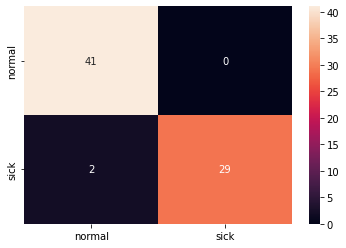

In [338]:
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['normal', 'sick'],yticklabels=['normal', 'sick'] )

We now label the unknown images.<br>
Let us first load them

In [339]:
def load_unknown_images():
    images_dir = Path('dataset1/unknown_images/')
    images = images_dir.glob('*.png')
    img_data = []
    for img in images:
        img_data.append(img)
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [340]:
df_unknown_images = load_unknown_images()

df_unknown_images.shape

(50, 1)

In [341]:
def prepare_dataset_unknown(images):
  
    data = []
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            data.append(img)
        return data
    
    d = prepare(images)
    #print(l)
    d = np.array(d)
    return d

In [342]:
unknown_data = prepare_dataset_unknown(df_unknown_images)

In [343]:
unknown_data.shape

(50, 224, 224, 3)

In [344]:
# Get predictions
pred = vgg_conv.predict(unknown_data, batch_size=16)
#print(pred)
pred = np.argmax(pred, axis=-1)
print(pred)


4/4 [==============================] - 10s 2s/step
[0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0
 1 0 0 1 1 0 1 1 1 0 0 1 0]
